In [20]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import re

In [6]:
# Load shock and ETF return data
shock_df = pd.read_csv("/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/EEUA_Shock_Annotated_Final.csv", parse_dates=["Date"])
etf_df = pd.read_csv("/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/green_brown_etf_returns.csv", parse_dates=["Date"])

In [8]:
data = pd.merge(etf_df, shock_df[['Date', 'Shock_ModelBased']], on='Date', how='inner')
data.set_index('Date', inplace=True)

# Function to run Local Projections
def run_local_projection(data, response_col, shock_col, horizons=[1, 3, 5, 10, 20]):
    irf_results = []
    for h in horizons:
        y = data[response_col].shift(-h) - data[response_col]  # future return minus current (cumulative return)
        X = sm.add_constant(data[shock_col])
        X, y = X.loc[y.dropna().index], y.dropna()
        model = sm.OLS(y, X).fit()

        irf_results.append({
            'Horizon': h,
            'Response': response_col,
            'Shock': shock_col,
            'Beta': model.params[shock_col],
            'SE': model.bse[shock_col],
            'P-value': model.pvalues[shock_col]
        })
    return pd.DataFrame(irf_results)

# Run IRFs for green (ICLN) and brown (XLE) ETFs
green_irf = run_local_projection(data, 'ICLN_Returns', 'Shock_ModelBased')
brown_irf = run_local_projection(data, 'XLE_Returns', 'Shock_ModelBased')

# Add ETF tags and combine results
green_irf['ETF'] = 'ICLN'
brown_irf['ETF'] = 'XLE'
combined_irf = pd.concat([green_irf, brown_irf])

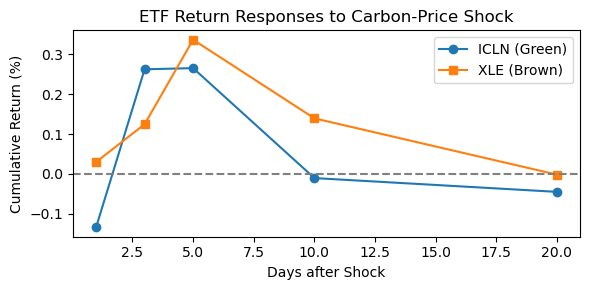

In [10]:
horizons = [1, 3, 5, 10, 20]
icln_beta = [-0.1336, 0.2619, 0.2649, -0.0103, -0.0448]
xle_beta  = [0.0299, 0.1244, 0.3360, 0.1392, -0.0017]

plt.figure(figsize=(6,3))
plt.plot(horizons, icln_beta, marker='o', label='ICLN (Green)')
plt.plot(horizons, xle_beta,  marker='s', label='XLE (Brown)')
plt.axhline(0, color='grey', linestyle='--')
plt.title('ETF Return Responses to Carbon-Price Shock')
plt.xlabel('Days after Shock')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.tight_layout()
plt.show()

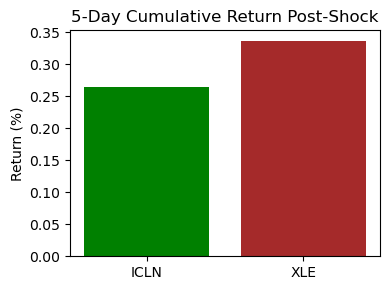

In [12]:
plt.figure(figsize=(4,3))
plt.bar(['ICLN','XLE'], [0.2649, 0.3360], color=['green','brown'])
plt.title('5-Day Cumulative Return Post-Shock')
plt.ylabel('Return (%)')
plt.tight_layout()
plt.show()

Columns in dataframe: ["('ICLN', 'ICLN')", "('XLE', 'XLE')", "('VIX', '^VIX')", "('Brent', 'BZ=F')", "('SP500', '^GSPC')", 'dgs10', 'carbon_eua']
Detected columns: ICLN=('ICLN', 'ICLN'), XLE=('XLE', 'XLE'), Brent=('Brent', 'BZ=F'), Carbon=carbon_eua, SP500=('SP500', '^GSPC'), DGS10=dgs10
Added difference column for dgs10: dgs10_diff
Returns columns created: ["('ICLN', 'ICLN')_ret", "('XLE', 'XLE')_ret", "('Brent', 'BZ=F')_ret", 'carbon_eua_ret', "('SP500', '^GSPC')_ret"]


/var/folders/xz/jw648p2x3yzgzbsn7frv0n9c0000gn/T/ipykernel_81407/4063527957.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


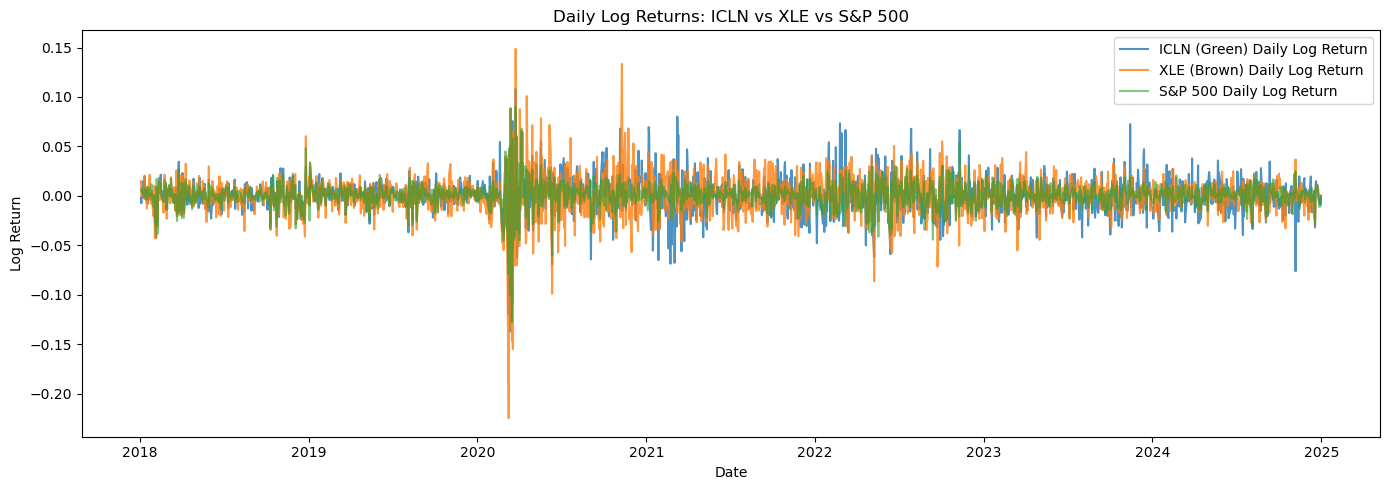

In [18]:
# Load the merged data
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_with_carbon_macro_2018_2024.csv', index_col=0, parse_dates=True)

print("Columns in dataframe:", df.columns.tolist())

# Robust auto-matching for asset columns
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

ICLN_col = find_col('ICLN', df.columns)
XLE_col = find_col('XLE', df.columns)
Brent_col = find_col('Brent', df.columns)
carbon_col = find_col('carbon_eua', df.columns)
SP500_col = find_col('SP500', df.columns)
dgs10_col = find_col('dgs10', df.columns)

print(f"Detected columns: ICLN={ICLN_col}, XLE={XLE_col}, Brent={Brent_col}, Carbon={carbon_col}, SP500={SP500_col}, DGS10={dgs10_col}")

assets = [col for col in [ICLN_col, XLE_col, Brent_col, carbon_col, SP500_col] if col is not None]

# Forward-fill missing data
df = df.fillna(method='ffill')

# Calculate log returns for present assets (ICLN, XLE, Brent, Carbon, SP500)
returns_added = []
for col in assets:
    ret_col = f'{col}_ret'
    df[ret_col] = np.log(df[col] / df[col].shift(1))
    returns_added.append(ret_col)

# For the 10-year Treasury yield, you may want the level and/or daily change
if dgs10_col and f'{dgs10_col}_diff' not in df.columns:
    df[f'{dgs10_col}_diff'] = df[dgs10_col].diff()
    print(f"Added difference column for {dgs10_col}: {dgs10_col}_diff")

print("Returns columns created:", returns_added)

# Visualize ICLN and XLE returns if present
plt.figure(figsize=(14, 5))
if ICLN_col and f'{ICLN_col}_ret' in df.columns:
    plt.plot(df.index, df[f'{ICLN_col}_ret'], label='ICLN (Green) Daily Log Return', alpha=0.8)
if XLE_col and f'{XLE_col}_ret' in df.columns:
    plt.plot(df.index, df[f'{XLE_col}_ret'], label='XLE (Brown) Daily Log Return', alpha=0.8)
if SP500_col and f'{SP500_col}_ret' in df.columns:
    plt.plot(df.index, df[f'{SP500_col}_ret'], label='S&P 500 Daily Log Return', alpha=0.6)
plt.title('Daily Log Returns: ICLN vs XLE vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Carbon shock threshold (1.5*std): 0.0410
Number of shock days detected: 191


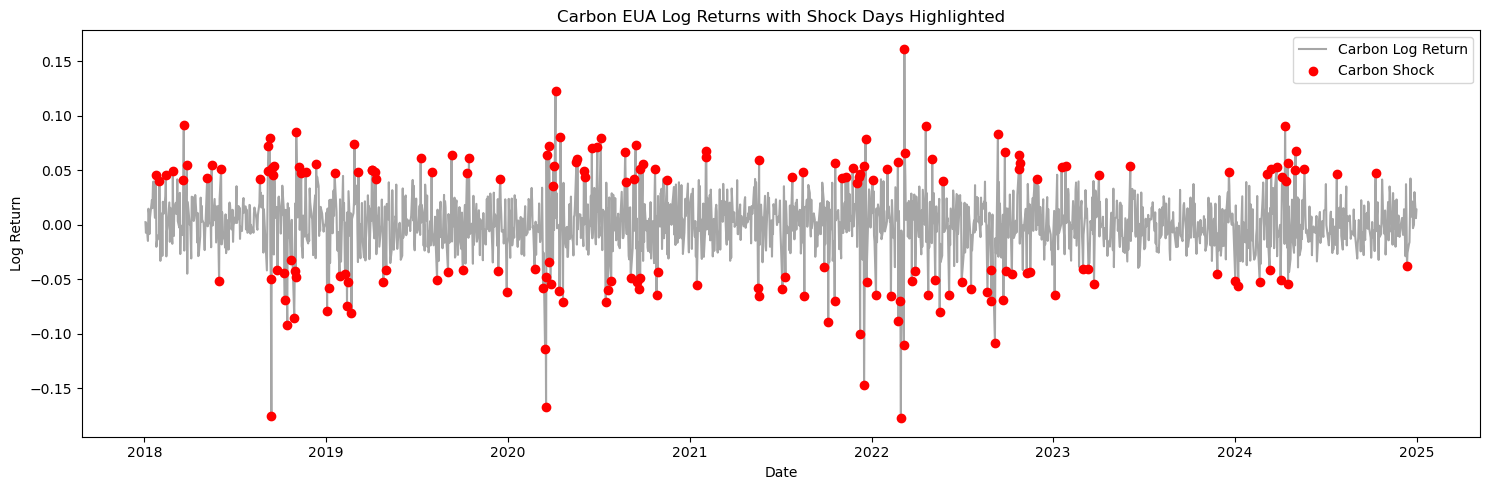

In [22]:
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_2018_2024.csv', index_col=0, parse_dates=True)

# 2. Detect carbon price and return columns (case-insensitive, robust)
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

carbon_col = find_col('carbon_eua', df.columns)
carbon_ret_col = find_col('carbon_eua_ret', df.columns)

if not carbon_ret_col:
    # If not already in file, compute log return for carbon price
    if carbon_col:
        df['carbon_eua_ret'] = np.log(df[carbon_col] / df[carbon_col].shift(1))
        carbon_ret_col = 'carbon_eua_ret'
    else:
        raise Exception("Could not find a carbon price or return column.")

# 3. Fit AR(5) model to carbon log returns to get residuals
carbon_ret = df[carbon_ret_col].dropna()
model = ARIMA(carbon_ret, order=(5, 0, 0))
fit = model.fit()
resid = fit.resid

# 4. Assign residuals to DataFrame
df.loc[resid.index, 'carbon_shock_resid'] = resid

# 5. Flag carbon shocks: abs(resid) > 1.5 * std
shock_threshold = 1.5 * np.std(resid)
df['carbon_shock'] = (df['carbon_shock_resid'].abs() > shock_threshold).astype(int)

print(f"Carbon shock threshold (1.5*std): {shock_threshold:.4f}")
print(f"Number of shock days detected: {df['carbon_shock'].sum()}")

# 6. OPTIONAL: Visualize shocks
plt.figure(figsize=(15,5))
plt.plot(df.index, df[carbon_ret_col], label='Carbon Log Return', color='gray', alpha=0.7)
plt.scatter(df[df['carbon_shock'] == 1].index, df.loc[df['carbon_shock'] == 1, carbon_ret_col],
            color='red', label='Carbon Shock', zorder=10)
plt.title('Carbon EUA Log Returns with Shock Days Highlighted')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.show()

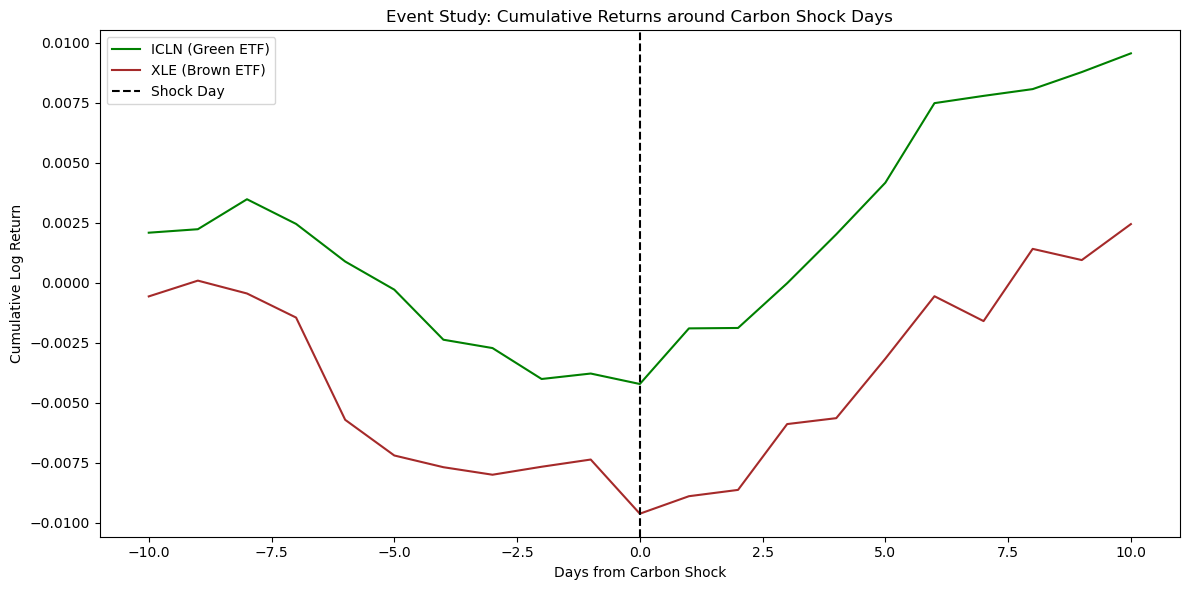


Average cumulative returns around shocks:
    days_from_shock  mean_cumret_icln  mean_cumret_xle
0               -10          0.002085        -0.000570
1                -9          0.002230         0.000088
2                -8          0.003479        -0.000449
3                -7          0.002451        -0.001452
4                -6          0.000884        -0.005714
5                -5         -0.000289        -0.007200
6                -4         -0.002375        -0.007689
7                -3         -0.002723        -0.008002
8                -2         -0.004012        -0.007670
9                -1         -0.003785        -0.007369
10                0         -0.004221        -0.009627
11                1         -0.001903        -0.008897
12                2         -0.001886        -0.008635
13                3         -0.000021        -0.005891
14                4          0.002017        -0.005645
15                5          0.004169        -0.003164
16                6   

In [24]:
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_2018_2024.csv', index_col=0, parse_dates=True)

# Helper to detect correct ETF columns
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

# Find ETF return columns
icln_col = find_col('ICLN', df.columns)
xle_col = find_col('XLE', df.columns)
icln_ret_col = f'{icln_col}_ret'
xle_ret_col = f'{xle_col}_ret'

# Safety check
if icln_ret_col not in df.columns or xle_ret_col not in df.columns:
    raise ValueError("Could not find ICLN or XLE return columns.")

# Find shock event indices (skip first/last 10 days to allow for window)
shock_indices = df.index[df['carbon_shock'] == 1]
shock_indices = [idx for idx in shock_indices if (df.index.get_loc(idx) > 10) and (df.index.get_loc(idx) < len(df)-10)]

window = 10  # Days before/after shock
event_matrix_icln = []
event_matrix_xle = []

for event_date in shock_indices:
    loc = df.index.get_loc(event_date)
    window_slice = slice(loc-window, loc+window+1)
    event_matrix_icln.append(df.iloc[window_slice][icln_ret_col].values)
    event_matrix_xle.append(df.iloc[window_slice][xle_ret_col].values)

event_matrix_icln = np.array(event_matrix_icln)
event_matrix_xle = np.array(event_matrix_xle)
event_time = np.arange(-window, window+1)

# Calculate average (mean) cumulative returns over event windows
mean_icln = np.nanmean(np.cumsum(event_matrix_icln, axis=1), axis=0)
mean_xle = np.nanmean(np.cumsum(event_matrix_xle, axis=1), axis=0)

# Plot event study result
plt.figure(figsize=(12,6))
plt.plot(event_time, mean_icln, label='ICLN (Green ETF)', color='green')
plt.plot(event_time, mean_xle, label='XLE (Brown ETF)', color='brown')
plt.axvline(0, color='black', linestyle='--', label='Shock Day')
plt.title('Event Study: Cumulative Returns around Carbon Shock Days')
plt.xlabel('Days from Carbon Shock')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.tight_layout()
plt.show()

# Show as table as well
result_table = pd.DataFrame({
    'days_from_shock': event_time,
    'mean_cumret_icln': mean_icln,
    'mean_cumret_xle': mean_xle
})
print("\nAverage cumulative returns around shocks:")
print(result_table.head(2*window+1))

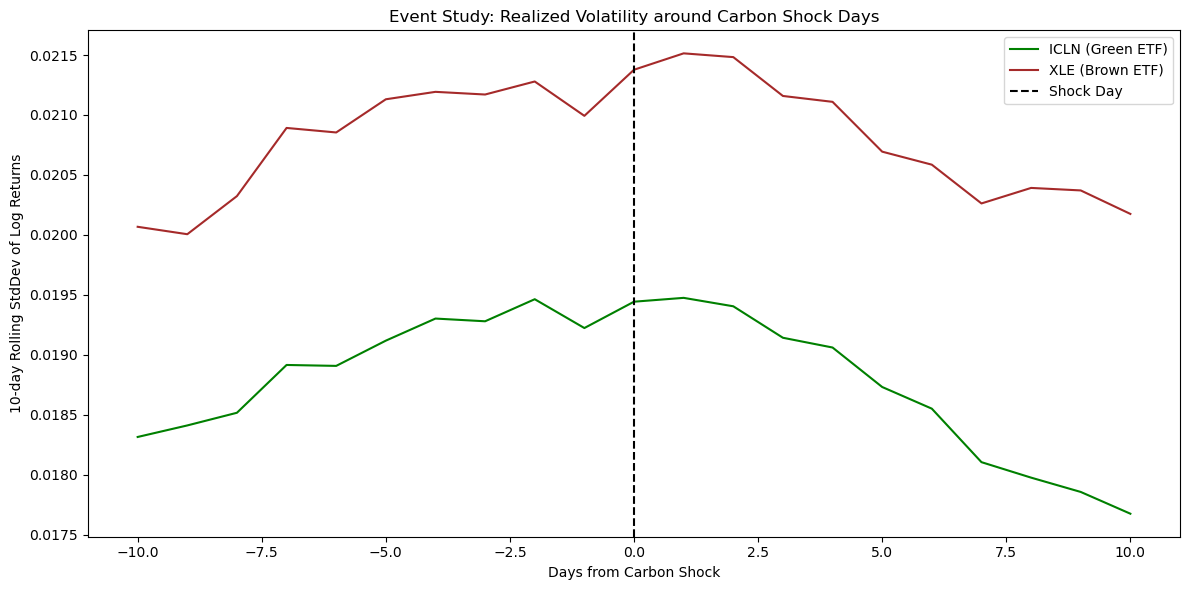

In [26]:
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_2018_2024.csv', index_col=0, parse_dates=True)

# Use the same robust detection of columns as before
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

icln_col = find_col('ICLN', df.columns)
xle_col = find_col('XLE', df.columns)
icln_ret_col = f'{icln_col}_ret'
xle_ret_col = f'{xle_col}_ret'

# Compute 10-day rolling realized volatility for ICLN and XLE
vol_window = 10
df['icln_vol'] = df[icln_ret_col].rolling(window=vol_window).std()
df['xle_vol'] = df[xle_ret_col].rolling(window=vol_window).std()

# Identify shock dates (avoid edges)
shock_indices = df.index[df['carbon_shock'] == 1]
shock_indices = [idx for idx in shock_indices if (df.index.get_loc(idx) > 10) and (df.index.get_loc(idx) < len(df)-10)]

window = 10
event_matrix_icln_vol = []
event_matrix_xle_vol = []

for event_date in shock_indices:
    loc = df.index.get_loc(event_date)
    window_slice = slice(loc-window, loc+window+1)
    event_matrix_icln_vol.append(df.iloc[window_slice]['icln_vol'].values)
    event_matrix_xle_vol.append(df.iloc[window_slice]['xle_vol'].values)

event_matrix_icln_vol = np.array(event_matrix_icln_vol)
event_matrix_xle_vol = np.array(event_matrix_xle_vol)
event_time = np.arange(-window, window+1)

# Calculate average event window volatility
mean_icln_vol = np.nanmean(event_matrix_icln_vol, axis=0)
mean_xle_vol = np.nanmean(event_matrix_xle_vol, axis=0)

# Plot
plt.figure(figsize=(12,6))
plt.plot(event_time, mean_icln_vol, label='ICLN (Green ETF)', color='green')
plt.plot(event_time, mean_xle_vol, label='XLE (Brown ETF)', color='brown')
plt.axvline(0, color='black', linestyle='--', label='Shock Day')
plt.title('Event Study: Realized Volatility around Carbon Shock Days')
plt.xlabel('Days from Carbon Shock')
plt.ylabel('10-day Rolling StdDev of Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


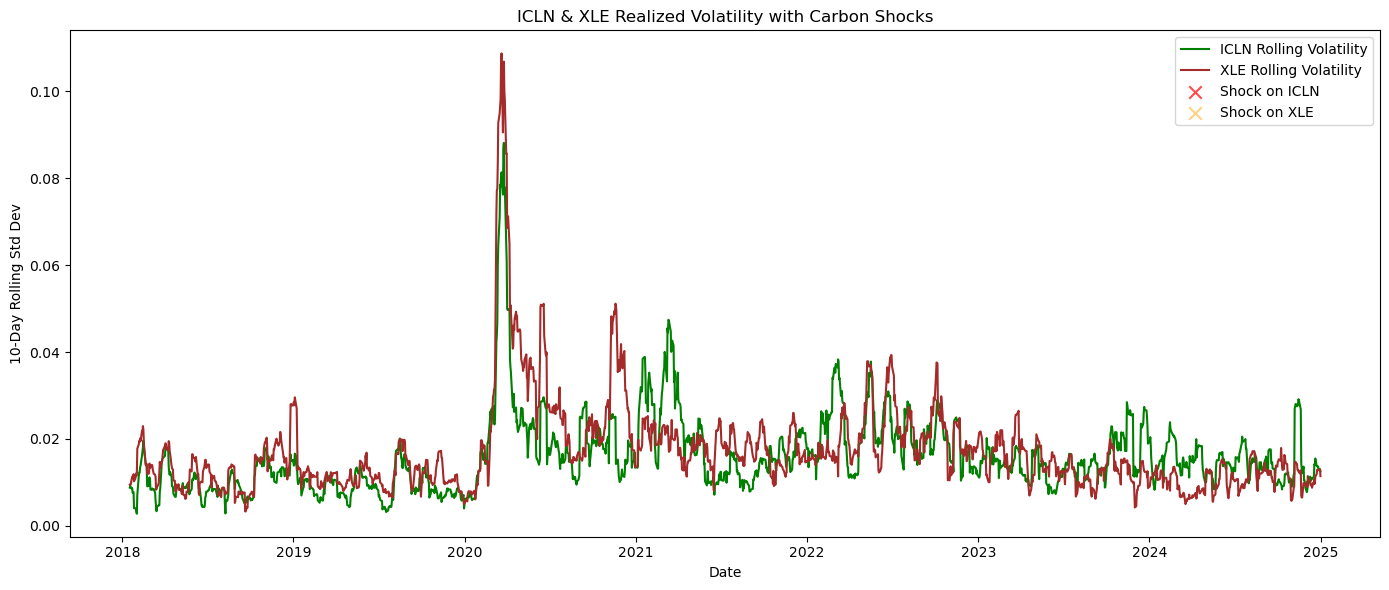

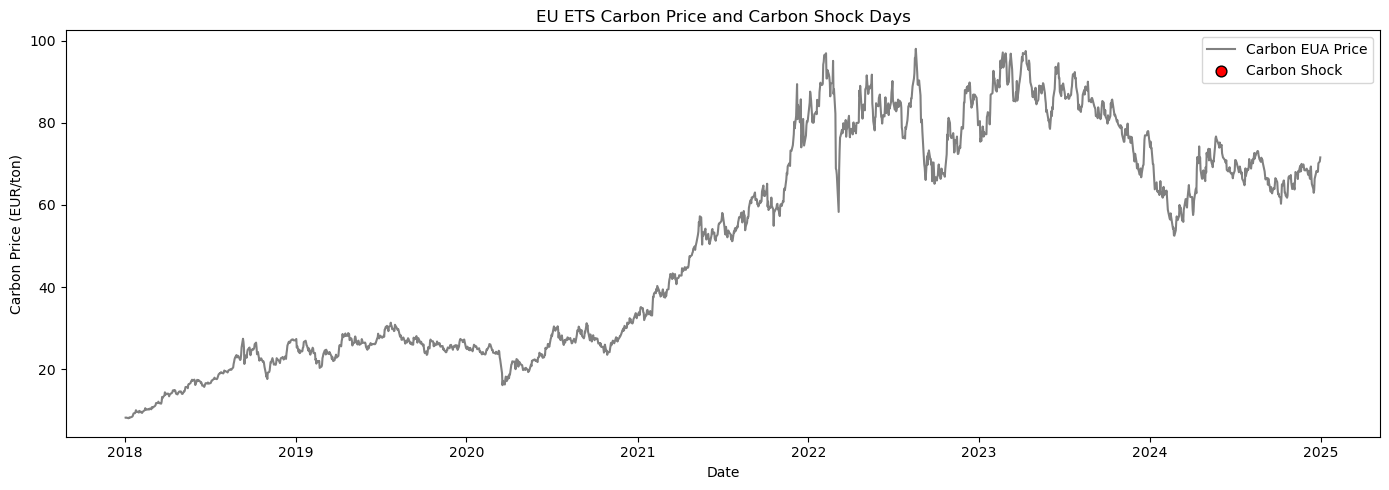

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

csv_path = '/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_garch_2018_2024.csv'
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df.columns = [clean_col(col) for col in df.columns]

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

icln_vol_col = find_col('icln_vol', df.columns)
xle_vol_col = find_col('xle_vol', df.columns)
carbon_col = find_col('carbon_eua', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

# If only residual is present, create carbon_shock flag
if not carbon_shock_col:
    resid_col = find_col('carbon_shock_resid', df.columns)
    if resid_col:
        resid = df[resid_col]
        threshold = 1.5 * np.nanstd(resid)
        df['carbon_shock'] = (resid.abs() > threshold).astype(int)
        carbon_shock_col = 'carbon_shock'

# Get shock dates
shock_dates = df.index[df[carbon_shock_col] == 1] if carbon_shock_col else []

# 1. ICLN & XLE Realized Volatility with Carbon Shocks
plt.figure(figsize=(14,6))
if icln_vol_col:
    plt.plot(df.index, df[icln_vol_col], label='ICLN Rolling Volatility', color='green')
if xle_vol_col:
    plt.plot(df.index, df[xle_vol_col], label='XLE Rolling Volatility', color='brown')
if carbon_shock_col and icln_vol_col:
    plt.scatter(shock_dates, df.loc[shock_dates, icln_vol_col], 
                color='red', marker='x', label='Shock on ICLN', alpha=0.7, s=80, zorder=10)
if carbon_shock_col and xle_vol_col:
    plt.scatter(shock_dates, df.loc[shock_dates, xle_vol_col], 
                color='orange', marker='x', label='Shock on XLE', alpha=0.5, s=80, zorder=10)
plt.title('ICLN & XLE Realized Volatility with Carbon Shocks')
plt.xlabel('Date')
plt.ylabel('10-Day Rolling Std Dev')
plt.legend()
plt.tight_layout()
plt.show()

# 2. EU ETS Carbon Price and Carbon Shock Days
plt.figure(figsize=(14,5))
if carbon_col:
    plt.plot(df.index, df[carbon_col], label='Carbon EUA Price', color='gray')
    if carbon_shock_col:
        plt.scatter(shock_dates, df.loc[shock_dates, carbon_col], 
                    color='red', label='Carbon Shock', s=60, edgecolor='black', zorder=10)
plt.title('EU ETS Carbon Price and Carbon Shock Days')
plt.xlabel('Date')
plt.ylabel('Carbon Price (EUR/ton)')
plt.legend()
plt.tight_layout()
plt.show()
